In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime


# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()


In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)
inspector.get_table_names()
columns =inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

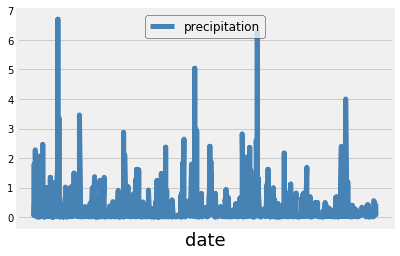

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results


# Calculate the date 1 year ago from the last data point in the database

# session.query(func.max(Measurement.date)).all()[0][0]
str_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
str_date=datetime.strptime(str_date, '%Y-%m-%d') - dt.timedelta(days=366)


# Perform a query to retrieve the data and precipitation scores

result=session.query(Measurement.date,Measurement.prcp).filter(Measurement.date > str_date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame (result,columns=['date','prcp'])
# Sort the dataframe by date
df=df.sort_values(by=['date'],ascending=False)
df.to_json(r"Resources/precipitation.json",orient='split')

df=df.set_index("date")
df=df.dropna()

# date=df["date"]
df=df.loc[df['prcp'] > 0.00]
# df=df.sort_values(by=['date','prcp'])
df=df.sort_values(by=['date'])


prcp=df["prcp"]

# Use Pandas Plotting with Matplotlib to plot the data


y_axis = prcp
x_axis = df.index.values
labels=["precipitation"]
plot1 = plt.plot(x_axis, y_axis, color='steelblue', linewidth=5)
plt.xlabel("date", fontsize=18)
plt.xticks([])

plt.legend(labels=labels, loc='upper center', fontsize='large', frameon=True, edgecolor='black')

# df.head()
# df.plot()


![precipitation](Images/precipitation.png)

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df=df.rename(columns={"prcp":"precipitation"})
df.describe()

,precipitation
count,1147.000000
mean,0.312363
std,0.576781
min,0.010000
25%,0.030000
50%,0.100000
75%,0.310000
max,6.700000


![describe](Images/describe.png)

In [14]:
# Design a query to show how many stations are available in this dataset?
session.query(Station).count()


9

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?

station_result=session.query(func.count(Measurement.tobs),func.max(Measurement.tobs),func.min(Measurement.tobs),func.avg(Measurement.tobs),Measurement.station).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
# List the stations and the counts in descending order.
station_result
print("Most active station {}".format(station_result[0][4]))
station_result

Most active station USC00519281


[(2772, 85.0, 54.0, 71.66378066378067, 'USC00519281'),
 (2724, 87.0, 56.0, 74.55323054331865, 'USC00519397'),
 (2709, 85.0, 59.0, 72.68918420081211, 'USC00513117'),
 (2669, 85.0, 56.0, 74.5436493068565, 'USC00519523'),
 (2612, 84.0, 58.0, 70.91500765696784, 'USC00516128'),
 (2202, 85.0, 58.0, 74.8732970027248, 'USC00514830'),
 (1979, 87.0, 53.0, 71.61596766043456, 'USC00511918'),
 (1372, 87.0, 58.0, 74.68440233236151, 'USC00517948'),
 (511, 83.0, 58.0, 72.72407045009784, 'USC00518838')]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
station_result
# df = pd.DataFrame (station_result)
# df
print("Most Max Temp is station {}".format(station_result[0][1]))
print("Most Min  Temp is station {}".format(station_result[0][2]))
print("Most Avg Temp is station {}".format(station_result[0][3]))
print("Station is {}".format(station_result[0][4]))


Most Max Temp is station 85.0
Most Min  Temp is station 54.0
Most Avg Temp is station 71.66378066378067
Station is USC00519281


Text(0, 0.5, 'Frequency')

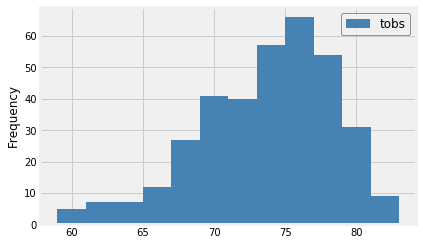

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Get last 12 month date for the station "USC00519281"
station_date=session.query(Measurement.date).filter(Measurement.station==station_result[0][4]).order_by(Measurement.date.desc()).first()[0]
station_date=datetime.strptime(station_date, '%Y-%m-%d') - dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores

result=session.query(Measurement.date,Measurement.tobs).filter(Measurement.station==station_result[0][4]).filter(Measurement.date > station_date).all()
station_df=pd.DataFrame(result)
plt.hist(station_df["tobs"],bins=12,facecolor='steelblue', label='tobs')
plt.legend(frameon=True, edgecolor='black', fontsize='large')
plt.ylabel("Frequency")

![precipitation](Images/station-histogram.png)

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [27]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
str_date_max=session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
# str_date=datetime.strptime(str_date, '%Y-%m-%d') - dt.timedelta(days=366)
str_date_min=session.query(Measurement.date).order_by(Measurement.date).first()[0]
# Get the years field from the previous years data
str_date_min_yr=datetime.strptime(str_date_min, '%Y-%m-%d').year
str_date_max_yr=datetime.strptime(str_date_max, '%Y-%m-%d').year
print(str_date_min_yr,str_date_max_yr)

temp_list=[]
peek2peek=[]
year=2010
while year <= 2017:
    start_dt=dt.date(year, 2 ,28)
    end_dt=dt.date(year, 3 ,5)
    temp_list.append(calc_temps(start_dt, end_dt)[0])
    peek2peek.append(calc_temps(start_dt, end_dt)[0][2]-calc_temps(start_dt, end_dt)[0][0])
    year=year+1

temp_df=pd.DataFrame(temp_list,columns=["TMIN","TAVG","TMAX"])
temp_df

2010 2017


,TMIN,TAVG,TMAX
0,63.0,68.477273,73.0
1,61.0,69.755102,75.0
2,62.0,69.571429,74.0
3,60.0,70.159091,75.0
4,57.0,67.644444,76.0
5,65.0,71.590909,78.0
6,62.0,69.886364,80.0
7,64.0,72.027778,78.0


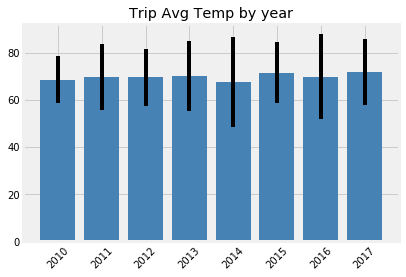

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

x_pos = ['2010', '2011', '2012','2013', '2014', '2015','2016','2017']
plt.bar(x_pos, temp_df["TAVG"],yerr=peek2peek, color='steelblue')
plt.title("Trip Avg Temp by year")
plt.xticks(rotation=45)

plt.show()

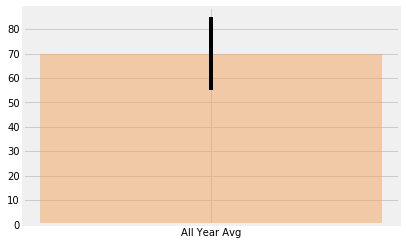

In [21]:
totalavg_plt = plt.bar('All Year Avg', temp_df["TAVG"].mean(), yerr=15, color='sandybrown', alpha=.5, label='Error bar is Min to Max Temp')


## Optional Challenge Assignment

In [22]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.

# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)
### Temperature Analysis II

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [24]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_dt='2018-3-1'
end_dt='2018-3-10'
str_date_day=datetime.strptime(start_dt, '%Y-%m-%d').day
end_date_day=datetime.strptime(end_dt, '%Y-%m-%d').day
str_date_mon=datetime.strptime(start_dt, '%Y-%m-%d').month
end_date_mon=datetime.strptime(end_dt, '%Y-%m-%d').month
myTravelDates=[]

# Use the start and end date to create a range of dates
normals=[]
while str_date_day <= end_date_day:
    if (len(str(str_date_mon))==1):
        cal_str_date_mon = "0" + str(str_date_mon)
    else:
        cal_str_date_mon=str(str_date_mon)
    if (len(str(str_date_day))==1):
        cal_str_date_day = "0" + str(str_date_day)
    else:
        cal_str_date_day=str(str_date_day)
        
    myDate=str(cal_str_date_mon)+"-"+str(cal_str_date_day)
    myTravelDates.append("2018-"+myDate)
    
    normals.append(daily_normals(myDate)[0])
    str_date_day=str_date_day+1
# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
normals,myTravelDates


([(64.0, 70.0327868852459, 76.0),
  (61.0, 70.36666666666666, 78.0),
  (60.0, 70.06896551724138, 78.0),
  (57.0, 69.27272727272727, 77.0),
  (60.0, 67.89090909090909, 76.0),
  (60.0, 69.20338983050847, 76.0),
  (60.0, 69.17241379310344, 78.0),
  (59.0, 68.72413793103448, 78.0),
  (57.0, 68.56140350877193, 75.0),
  (57.0, 69.12280701754386, 75.0)],
 ['2018-03-01',
  '2018-03-02',
  '2018-03-03',
  '2018-03-04',
  '2018-03-05',
  '2018-03-06',
  '2018-03-07',
  '2018-03-08',
  '2018-03-09',
  '2018-03-10'])

In [25]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df=pd.DataFrame(normals,columns=["tmin","tmax","tavg"])
df["TravelDated"]=myTravelDates
df.set_index("TravelDated")

,tmin,tmax,tavg
TravelDated,,,
2018-03-01,64.0,70.032787,76.0
2018-03-02,61.0,70.366667,78.0
2018-03-03,60.0,70.068966,78.0
2018-03-04,57.0,69.272727,77.0
2018-03-05,60.0,67.890909,76.0
2018-03-06,60.0,69.203390,76.0
2018-03-07,60.0,69.172414,78.0
2018-03-08,59.0,68.724138,78.0
2018-03-09,57.0,68.561404,75.0


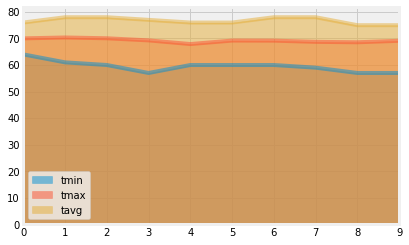

In [26]:
# Plot the daily normals as an area plot with `stacked=False`


df.plot.area(stacked=False)


